In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pathlib
from time import time

import keras
from keras import layers
from keras import backend as K
from keras.models import Model
from keras.metrics import binary_crossentropy
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train = x_train.astype('float32') / 255
x_train = x_train.reshape(x_train.shape + (1,)) # (60000, 28, 28) -> (60000, 28, 28, 1)

x_test = x_test.astype('float32') / 255
x_test = x_test.reshape(x_test.shape + (1,))

In [4]:
batch_size = 16
latent_dim = 2
img_shape = (28, 28, 1)
epochs = 10

A Variational Autoencoder (VAE) mapes an image to two vectors, $\mu$ and $\log (\sigma^2)$, that define a probability distribution (normally distributed) over the latent space. We sample from the distribution, then decode the sample to a reconstructed image.

## Encoder

In [5]:
img_input = keras.Input(shape=img_shape)
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(img_input)
x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
shape_before_flat = K.int_shape(x)

# Flatten to FC layer
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [6]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim)) # standard normal noise
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

## Decoder

In [7]:
decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(np.prod(shape_before_flat[1:]),
                 activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flat[1:])(x)
x = layers.Conv2DTranspose(32, (3, 3), padding='same',
                           activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [8]:
class CustomVAELayer(layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        # Flatten
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        xent_loss = binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

y = CustomVAELayer()([img_input, z_decoded])

In [9]:
vae = Model(img_input, y)
vae.compile(optimizer='rmsprop')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [10]:
history = vae.fit(x=x_train, y=None, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 23s 383us/step - loss: 0.2152 - val_loss: 0.1953
Epoch 2/10
60000/60000 [==============================] - 22s 369us/step - loss: 0.1917 - val_loss: 0.1895
Epoch 3/10
60000/60000 [==============================] - 22s 370us/step - loss: 0.1876 - val_loss: 0.1857
Epoch 4/10
60000/60000 [==============================] - 22s 366us/step - loss: 0.1852 - val_loss: 0.1835
Epoch 5/10
60000/60000 [==============================] - 22s 365us/step - loss: 0.1836 - val_loss: 0.1826
Epoch 6/10
60000/60000 [==============================] - 21s 358us/step - loss: 0.1825 - val_loss: 0.1829
Epoch 7/10
60000/60000 [==============================] - 22s 361us/step - loss: 0.1815 - val_loss: 0.1816
Epoch 8/10
60000/60000 [==============================] - 21s 356us/step - loss: 0.1807 - val_loss: 0.1813
Epoch 9/10
60000/60000 [==============================] - 21s 356us/step - loss: 0.1801 - val_

In [11]:
dirpath = "saved_models/vae/mnist/"
filename = str(round(time())) + ".h5"

pathlib.Path(dirpath).mkdir(parents=True, exist_ok=True)

vae.save(dirpath + filename)

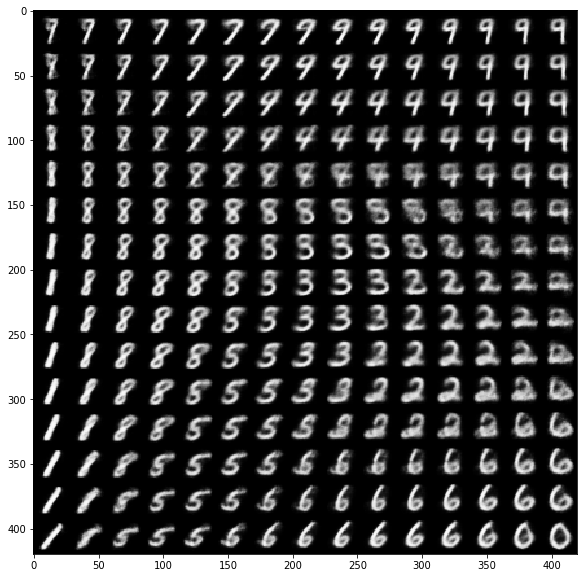

In [12]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()